In [1]:
#imports & helpers
import os, math, json, numpy as np, cv2, matplotlib.pyplot as plt
from skimage import color, filters, morphology, measure, segmentation, exposure, util
from skimage.filters import threshold_otsu, threshold_yen, threshold_triangle
from scipy import ndimage as ndi
import gc

np.random.seed(0)

def ensure_uint8(img):
    if img.dtype == np.uint8:
        return img
    return util.img_as_ubyte(img)

def as_rgb(img):
    if img.ndim == 2:
        img = np.stack([img]*3, axis=-1)
    if img.shape[-1] == 4:
        img = img[..., :3]
    return ensure_uint8(img)

def show(img, title='', cmap=None, figsize=(6,6)):
    plt.figure(figsize=figsize)
    if img.ndim == 2:
        plt.imshow(img, cmap=cmap or 'gray')
    else:
        plt.imshow(img)
    plt.title(title); plt.axis('off'); plt.show()

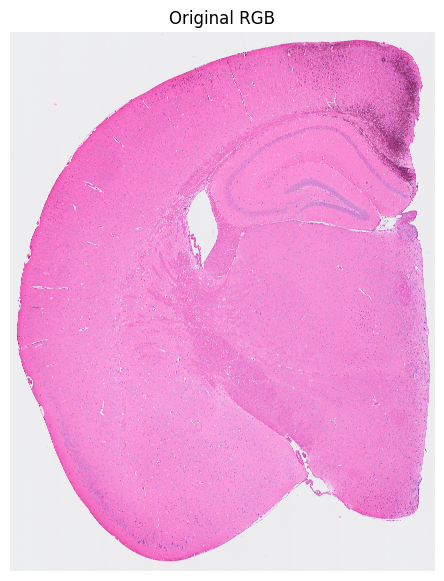

Image shape: (23947, 18872, 3) | dtype: uint8


In [2]:
# Cell 2: load image & set parameters
# youe image path
image_path = ".../Visium_HD_Mouse_Brain_tissue_image.tif"  # e.g., "../Visium_HD_Mouse_Brain_tissue_image.tif"

# scan resolution（µm/px），and aim diameter of nuclei（µm）
um_per_px = 0.5
nucleus_diam_um = 10.0

# 
try:
    from tifffile import imread as tiff_imread
    rgb = tiff_imread(image_path)
    if rgb.ndim == 3 and rgb.shape[-1] >= 3:
        rgb = rgb[..., :3]
except Exception:
    bgr = cv2.imread(image_path)
    if bgr is None:
        raise FileNotFoundError(f"Cannot read image: {image_path}")
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

rgb = as_rgb(rgb)
show(rgb, "Original RGB", figsize=(7,7))
print("Image shape:", rgb.shape, "| dtype:", rgb.dtype)

In [3]:
gc.collect()

2650

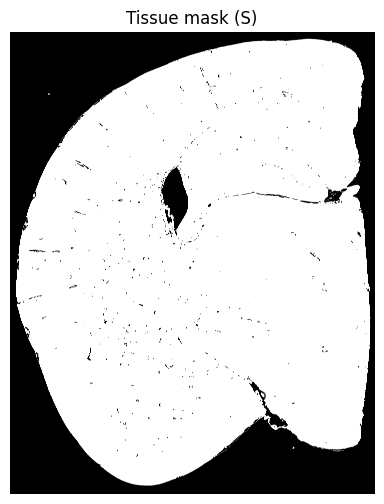

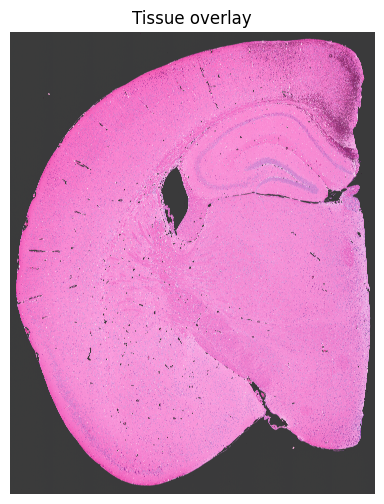

Tissue area fraction: 0.7336495292796603


In [4]:
# Cell 3: tissue mask (automatic)
def adaptive_kernel_px(um_per_px: float, nucleus_diam_um: float = 10.0) -> int:
    d_px = max(3, int(round(nucleus_diam_um / max(um_per_px, 1e-6))))
    if d_px % 2 == 0:
        d_px += 1
    return d_px

def get_tissue_mask(rgb, method="S", um_per_px=0.5, min_obj_um2=400.0):
    rgb = as_rgb(rgb)
    if method.lower().startswith("h"):  # hematoxylin
        hed = color.rgb2hed(rgb)
        chan = hed[..., 0]
        # 
        chan = exposure.rescale_intensity(-chan,
                                          in_range=(np.percentile(-chan, 2), np.percentile(-chan, 98)))
    else:  # "S" (HSV saturation)
        hsv = cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV)
        chan = hsv[..., 1] / 255.0

    thr = threshold_otsu(chan)
    mask = chan > thr

    # Area threshold converted according to resolution
    area_px_min = int(round((min_obj_um2 / (um_per_px ** 2))))
    mask = morphology.remove_small_objects(mask, area_px_min)
    mask = morphology.remove_small_holes(mask, area_px_min)

    k = adaptive_kernel_px(um_per_px, nucleus_diam_um=8.0)
    se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (k, k))
    mask = cv2.morphologyEx(mask.astype(np.uint8) * 255, cv2.MORPH_CLOSE, se) > 0
    return mask

tissue_method = "S"  # can change to "hematoxylin"
tissue_mask = get_tissue_mask(rgb, method=tissue_method, um_per_px=um_per_px)
show(tissue_mask.astype(np.uint8)*255, f"Tissue mask ({tissue_method})")

# Overlay Preview
overlay = rgb.copy()
overlay[~tissue_mask] = (overlay[~tissue_mask] * 0.25).astype(np.uint8)
show(overlay, "Tissue overlay")
print("Tissue area fraction:", tissue_mask.mean())

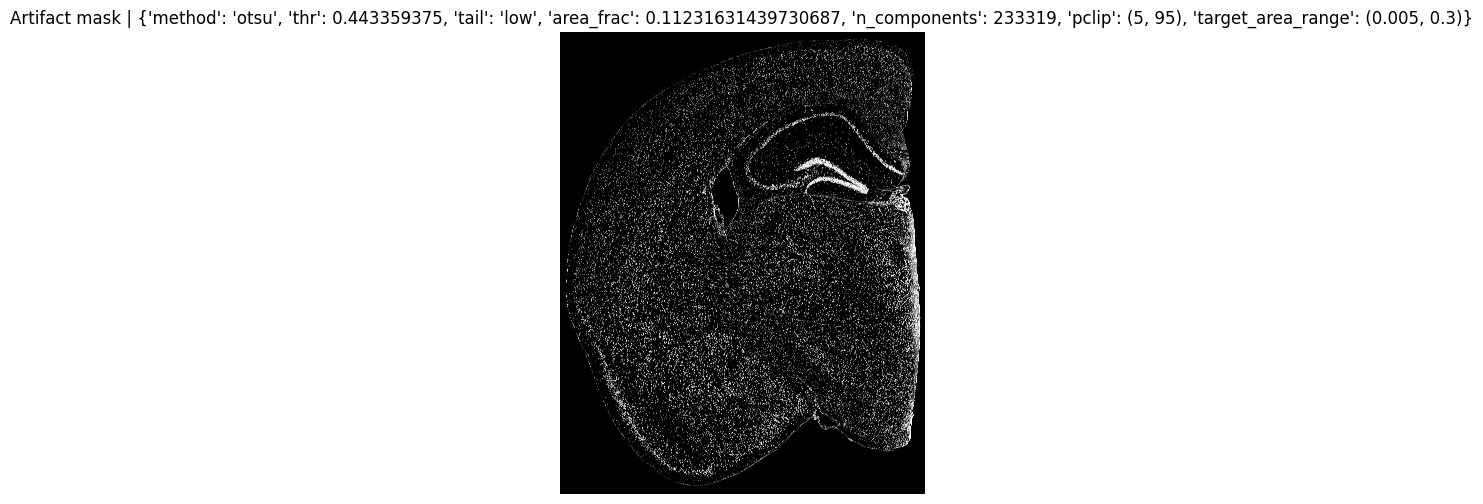

{'method': 'otsu', 'thr': 0.443359375, 'tail': 'low', 'area_frac': 0.11231631439730687, 'n_components': 233319, 'pclip': (5, 95), 'target_area_range': (0.005, 0.3)}


In [5]:
# Cell 4: robust hue-based artifact mask (automatic)
def robust_hue_artifact_mask(rgb, tissue_mask, pclip=(5,95), target_area_range=(0.005, 0.30)):
    rgb = as_rgb(rgb)
    hsv = cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV)
    H = hsv[..., 0].astype(np.float32)  # [0,179] OpenCV

    tissue_idx = tissue_mask > 0
    h_vals = H[tissue_idx]
    if h_vals.size == 0:
        return np.zeros(H.shape, bool), {"method": None, "area_frac": 0.0}

    lo, hi = np.percentile(h_vals, pclip)
    h_clip = np.clip(H, lo, hi)
    h_norm = (h_clip - lo) / max(hi - lo, 1e-6)  # [0,1]

    thr_candidates = []
    for mname, mfun in (("yen", threshold_yen), ("triangle", threshold_triangle), ("otsu", threshold_otsu)):
        try:
            thr = float(mfun(h_norm[tissue_idx]))
            thr_candidates.append((mname, thr))
        except Exception:
            pass

    def eval_mask(thr, pick_low):
        if pick_low:
            m = (h_norm <= thr) & tissue_idx
        else:
            m = (h_norm >= thr) & tissue_idx
        af = float(m.sum()) / float(tissue_idx.sum())
        return m, af

    best = None
    for mname, thr in thr_candidates:
        for tail in ("high", "low"):
            m, af = eval_mask(thr, pick_low=(tail=="low"))
            if target_area_range[0] <= af <= target_area_range[1]:
                labeled = measure.label(m)
                ncomp = labeled.max()
                score = af + 0.001*ncomp  # 面积主导，轻罚碎片
                if (best is None) or (score < best[0]):
                    best = (score, mname, thr, tail, af, ncomp, m)

    if best is None:
        # Fallback: Take the smaller area side of the extreme quantile
        q = 0.95
        thr_high = np.quantile(h_norm[tissue_idx], q)
        thr_low  = np.quantile(h_norm[tissue_idx], 1-q)
        m_high, af_high = eval_mask(thr_high, pick_low=False)
        m_low,  af_low  = eval_mask(thr_low,  pick_low=True)
        if af_high <= af_low:
            return m_high, {"method":"quantile","thr":thr_high,"tail":"high","area_frac":af_high,"pclip":pclip}
        else:
            return m_low, {"method":"quantile","thr":thr_low,"tail":"low","area_frac":af_low,"pclip":pclip}

    _, mname, thr, tail, af, ncomp, mask = best
    info = {"method":mname, "thr":thr, "tail":tail, "area_frac":af,
            "n_components":int(ncomp), "pclip":pclip, "target_area_range":target_area_range}
    return mask, info

artifact_mask, art_info = robust_hue_artifact_mask(rgb, tissue_mask, pclip=(5,95), target_area_range=(0.005,0.30))
show(artifact_mask.astype(np.uint8)*255, f"Artifact mask | {art_info}")
print(art_info)

In [6]:
# Cell 5: resolution-aware kernel size
k_px = adaptive_kernel_px(um_per_px, nucleus_diam_um=nucleus_diam_um)
print("Kernel (px) derived from resolution:", k_px)

Kernel (px) derived from resolution: 21


In [7]:
# Cell A — filter tiny nuclei from artifact_mask before preprocessing
import numpy as np
from skimage import morphology, measure

# Recommendation: Set the desired core diameter (µm). If undefined, use 10 µm.
try:
    nucleus_diam_um
except NameError:
    nucleus_diam_um = 10.0

def filter_small_nuclei(nuc_mask_bool, um_per_px, nucleus_diam_um=10.0,
                        min_area_um2=None, min_area_factor=0.25, fill_holes=True):
    """
    Connected regions with an area < (π*(d/2)^2)*min_area_factor are treated as "small nuclei/fragments" and removed.
    - If min_area_um2 is provided, filtering is performed directly based on this threshold (in µm²).
    """
    nuc_mask_bool = nuc_mask_bool.astype(bool)
    expected_um2 = np.pi * (nucleus_diam_um/2.0)**2
    thr_um2 = float(min_area_um2) if (min_area_um2 is not None) else expected_um2 * float(min_area_factor)
    thr_px  = int(round(thr_um2 / (um_per_px**2)))

    n_before = measure.label(nuc_mask_bool).max()
    out = morphology.remove_small_objects(nuc_mask_bool, min_size=max(1, thr_px))
    if fill_holes:
        out = morphology.remove_small_holes(out, area_threshold=max(1, thr_px))
    n_after = measure.label(out).max()

    info = {
        "n_before": int(n_before), "n_after": int(n_after),
        "removed": int(n_before - n_after),
        "min_area_um2": round(thr_um2, 2), "min_area_px": int(thr_px),
        "nucleus_diam_um": float(nucleus_diam_um), "um_per_px": float(um_per_px),
    }
    return out, info

artifact_mask_filt, filt_info = filter_small_nuclei(
    artifact_mask, um_per_px, nucleus_diam_um=nucleus_diam_um,
    min_area_um2=None,        
    min_area_factor=0.25,     # More aggressive can be adjusted to 0.35–0.4; more conservative 0.15–0.2
    fill_holes=True
)
print("Tiny nuclei filtering:", filt_info)

Tiny nuclei filtering: {'n_before': 233319, 'n_after': 36653, 'removed': 196666, 'min_area_um2': 19.63, 'min_area_px': 79, 'nucleus_diam_um': 10.0, 'um_per_px': 0.5}


In [8]:
# Cell B — Scheme 1 (no black-hat): keep nuclei (filtered) + pink background with robust band
import numpy as np, cv2
from scipy.stats import median_abs_deviation as mad

def keep_nuclei_and_pink_no_bh(
    rgb, tissue_mask, nuclei_mask,     
    q_width=0.30, k_s=2.0, k_v=2.0,    
    nucleus_dilate_px=0,
    smooth_replaced=True, k_px_for_smooth=9
):
    hsv = cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV)
    H = hsv[...,0].astype(np.float32)                # 0–179
    S = hsv[...,1].astype(np.float32) / 255.0
    V = hsv[...,2].astype(np.float32) / 255.0

    
    if nucleus_dilate_px > 0:
        k = nucleus_dilate_px if nucleus_dilate_px % 2 == 1 else nucleus_dilate_px+1
        se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (k, k))
        nuclei_safe = cv2.dilate(nuclei_mask.astype(np.uint8), se).astype(bool)
    else:
        nuclei_safe = nuclei_mask.astype(bool)

    domain = (tissue_mask.astype(bool) & (~nuclei_safe))
    if domain.sum() == 0:
        return rgb.copy(), {'note':'empty domain'}, {'replace_mask': np.zeros(H.shape, bool)}

    # 1) Hue Circle Mean (S-weighted)
    theta = H[domain] / 180.0 * 2*np.pi
    w = np.clip(S[domain], 0.05, None)
    mu_x = np.sum(w*np.cos(theta)) / (w.sum()+1e-9)
    mu_y = np.sum(w*np.sin(theta)) / (w.sum()+1e-9)
    mu = np.arctan2(mu_y, mu_x)

    # 2) Constructing a "Pink Belt": q_width quantile of Hue circle distance + MAD constraint of S/V + wide quantile boundary
    theta_all = H / 180.0 * 2*np.pi
    d = np.abs(np.angle(np.exp(1j*(theta_all - mu))))
    d_thr = np.quantile(d[domain], q_width)

    S_dom, V_dom = S[domain], V[domain]
    S_med, V_med = np.median(S_dom), np.median(V_dom)
    S_mad = mad(S_dom, scale='normal') + 1e-6
    V_mad = mad(V_dom, scale='normal') + 1e-6
    s_lo, s_hi = np.percentile(S_dom, (5, 99.5))
    v_lo, v_hi = np.percentile(V_dom, (2, 99.8))

    pink_mask_core = (d <= d_thr) \
                     & (np.abs(S - S_med) <= k_s * S_mad) \
                     & (np.abs(V - V_med) <= k_v * V_mad) \
                     & (S >= s_lo) & (S <= s_hi) & (V >= v_lo) & (V <= v_hi) \
                     & tissue_mask & (~nuclei_safe)

    # 3) Replace: Only replace non-nuclear & non-pink tissue pixels
    replace_mask = domain & (~pink_mask_core)

    # 4) Pink reference (median HSV)
    sel = pink_mask_core if pink_mask_core.sum() >= 500 else domain
    med_h = np.median(H[sel]).astype(np.uint8)
    med_s = (np.median(S[sel]*255)).astype(np.uint8)
    med_v = (np.median(V[sel]*255)).astype(np.uint8)
    pink_ref = np.array([med_h, med_s, med_v], dtype=np.uint8)

    out_hsv = hsv.copy()
    out_hsv[replace_mask] = pink_ref
    out = cv2.cvtColor(out_hsv, cv2.COLOR_HSV2RGB)

    # 5) Only slightly double the replacement area
    if smooth_replaced and replace_mask.any():
        sm = cv2.bilateralFilter(out, d=max(5,k_px_for_smooth), sigmaColor=40, sigmaSpace=max(5,k_px_for_smooth))
        out = np.where(replace_mask[...,None], sm, out)

    info = {
        'mu_h': float(((mu % (2*np.pi)) / (2*np.pi) * 180.0)),
        'q_width': float(q_width), 'd_thr': float(d_thr),
        'S_med': float(S_med), 'V_med': float(V_med),
        'S_mad': float(S_mad), 'V_mad': float(V_mad),
        's_lo': float(s_lo), 's_hi': float(s_hi), 'v_lo': float(v_lo), 'v_hi': float(v_hi),
        'pink_frac_core': float(pink_mask_core.sum())/float(tissue_mask.sum()+1e-9),
        'replaced_frac': float(replace_mask.sum())/float(tissue_mask.sum()+1e-9),
        'nucleus_dilate_px': int(nucleus_dilate_px)
    }
    return out, info, {'replace_mask': replace_mask, 'nonpink_mask': (domain & (~pink_mask_core)), 'nuclei_mask_used': nuclei_safe}



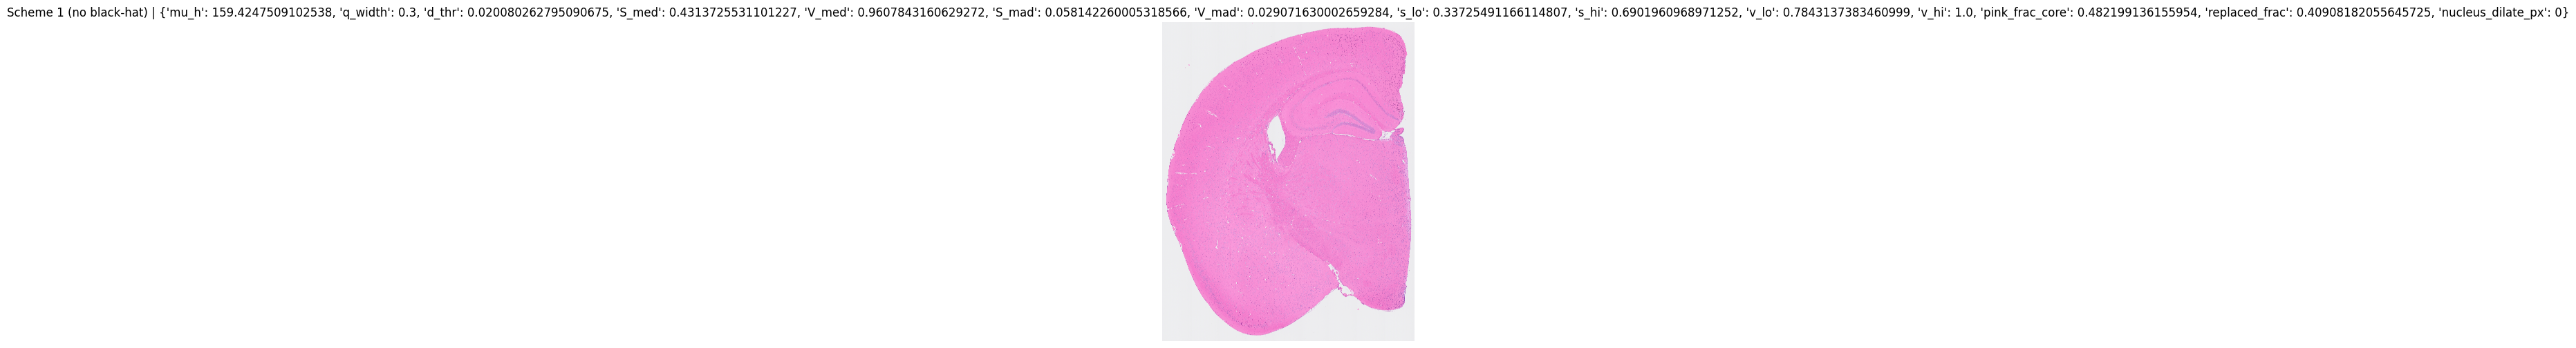

In [11]:
img_keep_pink, info_pink, masks_pink = keep_nuclei_and_pink_no_bh(
    rgb, tissue_mask, artifact_mask_filt,
    q_width=0.30, k_s=2.0, k_v=2.0,        
    nucleus_dilate_px=0,                   
    smooth_replaced=True, k_px_for_smooth=k_px
)
show(img_keep_pink, f"Scheme 1 (no black-hat) | {info_pink}")

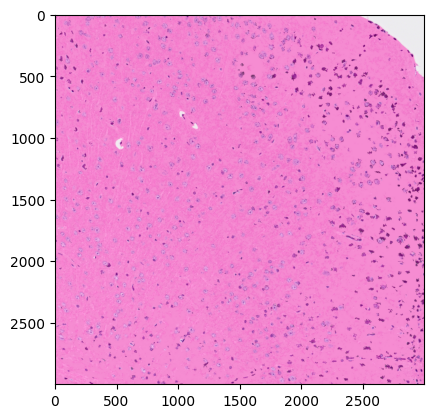

In [12]:
crop_img = img_keep_pink[800:3800, 15000:18000]
plt.imshow(crop_img)

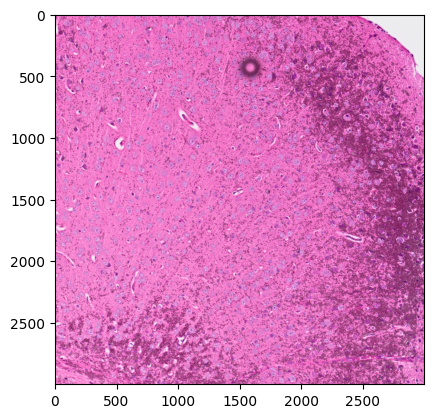

In [13]:
crop_img = rgb[800:3800, 15000:18000]
plt.imshow(crop_img)